# Numerical estimating the SCGF for 1D diffusion in a quadratic potential
$$dX_t = -X^3_t dt + \sqrt{2\epsilon}dW_t $$
We consider the following dynamical observable:
$$A_T = \frac{1}{T}\int_0^T X_t(X_t+1)dt$$

In [1]:
import numpy as np
import torch
import time
import os
import sys
import torchsde
from torch import nn
import matplotlib.pyplot as plt
from tqdm import trange

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
rc('xtick', labelsize=14)
rc('ytick', labelsize=14) 

## Defining the neural network

defining a DeepRitz block: $L_i(s) = \phi[W_{i2}\cdot\phi(W_{i1}\cdot s +b_{i1}) + b_{i2}] + s$

In [2]:
class DeepRitz_block(nn.Module):
    def __init__(self, h_size):
        super(DeepRitz_block, self).__init__()
        self.dim_h = h_size

        self.activation_function = nn.Tanh()
        block = [nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function,
                 nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function]
        self._block = nn.Sequential(*block)
    def forward(self, x):
        return self._block(x) + x

defining the neural network constructed by DeepRitz blocks: $\delta u_\theta(X, \lambda) = W\cdot L_n \otimes \dots \otimes L_1(X, \lambda)$

In [3]:
class Neural_Network(nn.Module):
    def __init__(self, in_size, h_size = 10, block_size = 1, dev="cpu"):
        super(Neural_Network, self).__init__()
        self.num_blocks = block_size
        self.dim_x = in_size
        self.dim_h = h_size
        self.dev = dev
        self.dim_input = self.dim_x + 1
        
        # assemble the neural network with DeepRitz blocks
        self._block = DeepRitz_block(self.dim_h)
        if self.dim_h > self.dim_input:
            model = [nn.ConstantPad1d((0, self.dim_h - self.dim_input), 0)]
        else:
            model = [nn.Linear(self.dim_input, self.dim_h)]
        for _ in range(self.num_blocks):
            model.append(self._block)
        model.append(nn.Linear(self.dim_h, self.dim_x))
        self._model = nn.Sequential(*model)

    def forward(self, x, k):
        return self._model( torch.cat([x, k*torch.ones([*x.shape[:-1], 1]).to(self.dev)], -1) )

## defining the system of interest
$dX_t = [b(X_t) + \delta u_\theta(X_t, \lambda)]dt + \sqrt{2\epsilon}dW_t$

In [4]:
class ODE(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return -x**3
    
class SDE(nn.Module):
#     sde_type = 'stratonovich'
    sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, Drift, Diffusion, h_size = 10, blocks_size = 1, unit_size=10., dev = "cpu"):
        super(SDE, self).__init__()
        self.dim_x = Diffusion.size(1)
        self._drift_0 = Drift.to(dev)

        # const diffusion matrix D:
        self._diffusion = Diffusion
    
    # the trial driven force u(x)
    def drift(self, t, x):
        return neural_network(x, lambdas) + self._drift_0(x)
    
    # the diffusion matrix
    def diffusion(self, t, x):
        return self._diffusion.expand(x.size(0), self.dim_x, self.dim_x)

    # the drift b(x)
    def drift_0(self, t, x):
        return self._drift_0(x)

## Learning SCGF
(Here we set the hidden layer demension to be 20 for demonstration purpose, more accurate estimation requires larger size, e.g., 50, or more training steps)

In [5]:
dim_x, dim_h, num_blocks = 1, 20, 2

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
print(dev)
neural_network = Neural_Network(dim_x, dim_h, num_blocks, dev).to(dev)
Psi = []
A_T = []
K_T = []

epsilon = 0.01
D = 2 * epsilon
diffusion = torch.tensor( np.sqrt(D) * np.eye(dim_x)).float().to(dev)

ode = ODE()
sde = SDE(ode, diffusion, dim_h, num_blocks, dev).to(dev)
sde_method = 'euler' if sde.sde_type == 'ito' else 'modpoint'

cuda:0


In [6]:
Bias = 1./epsilon * torch.linspace(-1,1,11)           # 11 lambda from -1 to 1
batch_size = 50                                       # batch size for each lambda
batch_size_tot = batch_size * Bias.shape[0]
dt = 1e-3                                             # time step
T = 5.                                                # duration of sampled trajectories
LR =5e-3                                              # learning rate

x_init = torch.zeros([batch_size_tot, dim_x]).to(dev)
lambdas = Bias.repeat(batch_size,1).t().reshape([-1,1]).to(dev)

optimizer = torch.optim.Adagrad(neural_network.parameters(), lr = LR)

In [ ]:
ts = torch.arange(0, T+dt, dt).to(dev)
step = 0
while step < 500:
    start_time = time.time()

    optimizer.zero_grad()

    # generate trajectories according to the controlled process
    bm = torchsde.BrownianInterval(t0=ts[0], t1=ts[-1], size=(batch_size_tot, 1),device=dev)
    traj = torchsde.sdeint(sde, x_init.to(dev), ts, dt = dt, bm=bm,
                           method=sde_method, names={'drift': 'drift', 'diffusion': 'diffusion'})
    
        
    # compute the loss function
    delta_u = neural_network(traj, lambdas.expand([*traj.shape[:-1],1]))[:-1]
    K = 1/2 * 1/D * torch.sum(delta_u**2, (0,-1)) *dt/T
    A = torch.sum(traj*(traj+1), (0,-1)) * dt/T
    loss_batch = (K - lambdas.squeeze() * A)
    loss = loss_batch.mean()

    assert not torch.isnan(loss), "We've got a NaN"

    loss.backward()

    resample = False
    for p in neural_network.parameters():
        if p.grad.max() > 1e6:
            resample = True
            print("We need to re-sample", p.grad.max())
            break
    if resample == False:
        Psi.append(loss_batch.cpu().detach().numpy())
        K_T.append(K.cpu().detach().numpy())
        A_T.append(A.cpu().detach().numpy())
        step += 1
        x_init = traj[-1].detach()
        optimizer.step()  
        
        # (Optional) Replica Exchange:
#         with torch.no_grad():
#                 swap = np.random.choice(batch_size_tot, 2)
#                 M_T = ((traj[:-1,swap[0]] - (F+F0)[:,swap[0]])**2).sum() * dt
#                 - ((traj[:-1,swap[1]] - (F+F0)[:,swap[1]])**2).sum()* dt
#                 if np.random.rand() < torch.exp(M_T /4):
#                     x_init[[swap[0],swap[1]]] = x_init[[swap[1],swap[0]]] 

        t_simul = time.time()
        print('step %i - time: %.2f sec - loss: %.4f - k * %.4f = %.4f' 
              % (step, float(t_simul-start_time), 
                 np.mean(K_T[-1]), np.mean(A_T[-1]), np.mean(Psi[-1])*epsilon))

## Plotting the time evolution of the estimator

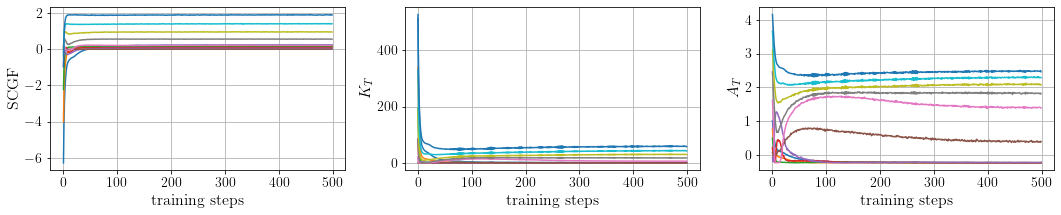

In [8]:
SCGF = -epsilon * np.array(Psi).reshape([len(Psi),Bias.size(0),-1]).mean(-1)
K = np.array(K_T).reshape([len(K_T),Bias.size(0),-1]).mean(-1)
A = np.array(A_T).reshape([len(A_T),Bias.size(0),-1]).mean(-1)

plt.figure(figsize=(18,3))
plt.subplot(1,3,1)
plt.plot(SCGF)
plt.grid()
plt.ylabel('SCGF',fontsize=16)
plt.xlabel('training steps',fontsize=16)
plt.subplot(1,3,2)
plt.plot(K)
plt.grid()
plt.ylabel(r'$K_T$',fontsize=16)
plt.xlabel('training steps',fontsize=16)
plt.subplot(1,3,3)
plt.plot(A)
plt.grid()
plt.ylabel(r'$A_T$',fontsize=16)
plt.xlabel('training steps',fontsize=16)
plt.show()

## Comparing the the exact solution at zero-noise limit
T. Nemoto et al. has shown that in the limit $\epsilon\rightarrow0$, the SCGF can be solved analytically:
$$\psi_{\epsilon\rightarrow0}(\lambda) = \max_q\{ -\frac{1}{4} q^6 + \lambda(q^2+q) \}$$

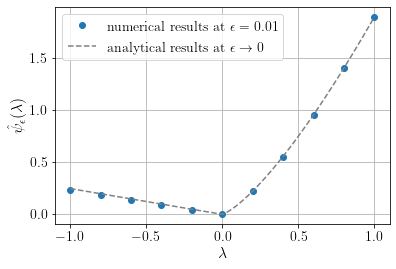

In [9]:
h = np.linspace(-1,1,1000)[None]
x = np.linspace(-10,10,1000)[None].T
G = np.max(-1/4*x**6 + (x**2 + x) @ h, 0)

fig, ax = plt.subplots()
ax.plot(Bias * epsilon, SCGF[-10:].mean(0),'o', label=r'numerical results at $\epsilon=0.01$')
ax.plot(h.squeeze(),G,'--',color='grey', label=r'analytical results at $\epsilon\rightarrow0$')
ax.set_xlabel(r'$\lambda$',fontsize=16)
ax.set_ylabel(r'$\hat{\psi}_{\epsilon}(\lambda)$',fontsize=16)
ax.grid()
plt.legend(fontsize=14)
plt.show()